In [1]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
import pickle
from numpy import genfromtxt
import pandas as pd
from joblib import Parallel, delayed
import multiprocessing as mp
import scipy.io
from tqdm import tqdm_notebook as tqdm
import h5py
import math

In [2]:
import sys
from mgcpy.independence_tests.dcorr import DCorr
from mgcpy.benchmarks.power_two_sample import power, power_given_data
from mgcpy.benchmarks.simulations import *
from mgcpy.independence_tests.mgc.mgc import MGC
from mgcpy.independence_tests.rv_corr import RVCorr
from mgcpy.independence_tests.hhg import HHG
from mgcpy.independence_tests.kendall_spearman import KendallSpearman

In [3]:
simulations = {'multi_indept': (multi_indep_sim, 20)}

In [4]:
def power_vs_dimension_parallel(params_dict):
    dims = [1, 3, 4, 5, 7, 9, 10]
    estimated_power = np.zeros(len(dims))
    test = params_dict['independence_test']
    sim = params_dict['simulation_type']
    print(sim, test.get_name())
    
    for i in range(len(dims)):
        estimated_power[i] = power_given_data(test, sim, data_type='dimension', num_samples=100, num_dimensions=dims[i], theta=0)
    
    np.savetxt('{}_{}_dimension_matlab_new.csv'.format(sim, test.get_name()), estimated_power, delimiter=',')
    print('{} {} finished'.format(sim, test.get_name()))
    return (params_dict, estimated_power)

In [5]:
def fill_params_dict_list_dim():
    mcorr = DCorr(which_test='unbiased')
    dcorr = DCorr(which_test='biased')
    mantel = DCorr(which_test='mantel')
    mgc = MGC()
    pearson = RVCorr(which_test='pearson')
    rv_corr = RVCorr(which_test='rv')
    cca = RVCorr(which_test='cca')
    independence_tests = [mcorr, dcorr, mantel, mgc, pearson, rv_corr, cca]
    
    params_dict_list = []
    for sim_name, sim_func in simulations.items():
        for test in independence_tests:
            params_dict = {'independence_test': test, 'simulation_type': sim_func[1]}
            params_dict_list.append(params_dict)
    return params_dict_list

In [6]:
%%time
params_dict = fill_params_dict_list_dim()
print(type(params_dict))
pool = mp.Pool(mp.cpu_count()-1)
results = pool.map(power_vs_dimension_parallel, params_dict)

<class 'list'>
20 unbiased
20 biased
20 mantel
20 mantel finished
20 mgc
20 biased finished
20 pearson
20 unbiased finished
20 rv
20 rv finished
20 cca
20 pearson finished
20 cca finished
20 mgc finished
CPU times: user 1.51 s, sys: 346 ms, total: 1.85 s
Wall time: 46min 13s


In [9]:
def plot_all_curves():
    simulation_names = ['linear', 'exponential', 'cubic','joint_normal', 'step', 'quadratic', 'w_shape', 'spiral', 
                         'bernoulli', 'log', 'fourth_root', 'sine_4pi',
                       'sine_16pi', 'square', 'two_parabolas', 'circle', 'ellipse', 'diamond', 'multi_noise',
                        'multi_indept']
        
        
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(14,12)) 
    simulation_type=0
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            sim_name = simulation_names[simulation_type]
            simulation_type += 1
            tests = ['mgc', 'unbiased', 'biased', 'mantel', 'pearson', 'rv', 'cca']
            #mgc_power = np.genfromtxt('{}_mgc_angle_matlab_new.csv'.format(simulation_type), delimiter=',')

            for test in tests:
                power = np.genfromtxt('{}_{}_dimension_matlab_new.csv'.format(simulation_type, test), delimiter=',')
                x_axis = [1,3,4,5,7,9,10]
                col.plot(x_axis, power, label=test)
                col.set_ylim(-0.25, 1.25)
                col.set_yticks([-0.25, 0, 0.25, 0.50, 0.75, 1.00])
                col.set_title(sim_name) 
    plt.legend()
    plt.subplots_adjust(hspace=.75)
    fig.suptitle('Power of Changing Angle')
    plt.savefig('power_curves_dimension_trial')

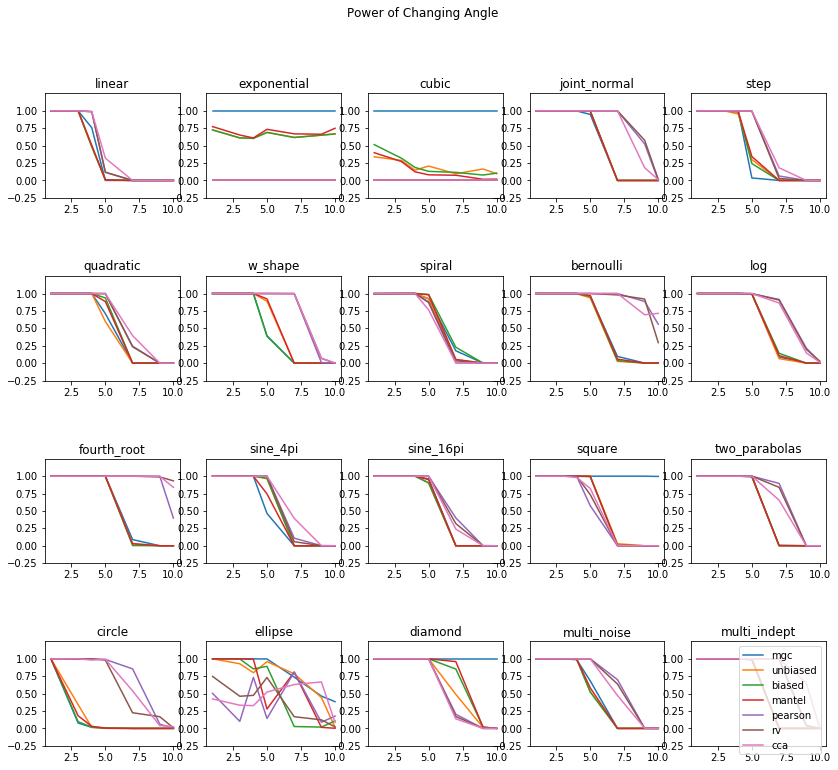

In [10]:
plot_all_curves()